# Prospective Dynamic LCIA Demo

This notebook showcases the **prospective dynamic LCIA** capabilities of the `dynamic_characterization` package using Brightway and bw_temporalis.

Prospective dynamic LCIA accounts for how climate impacts change under different future emission scenarios. Unlike "standard" dynamic LCIA, prospective characterization uses **scenario-dependent radiative efficiencies** that evolve based on projected atmospheric concentrations from integrated assessment models (IAMs). Our implementations bases on the work of [Watanabe et al.](https://pubs.acs.org/doi/10.1021/acs.est.5c12391)) - so check out their paper for more background infos.

**Key Features Demonstrated Here:**
- **Usage with Brightway**: Calculate a dynamic inventory from a Brightway LCA model (e.g., from [bw_temporalis](https://github.com/brightway-lca/bw_temporalis) or [bw_timex](https://github.com/brightway-lca/bw_timex)) and characterize it using prospective dynamic LCIA
- **Scenario Selection**: Choose from SSP/RCP scenarios (e.g., SSP1-RCP2.6, SSP2-RCP4.5, SSP5-RCP8.5) and IAMs (IMAGE, MESSAGE, REMIND)
- **Time-varying RE**: Option to let radiative efficiency evolve over the gas decay period (`time_varying_re=True`) or fix it at emission year (`time_varying_re=False`)
- **Comparison with Standard Dynamic LCIA**: Results are compared against IPCC AR6-based characterization to illustrate the effect of considering future scenarios

## 1. Brightway setup

First, we set up the Brightway project with the ecoinvent biosphere database.

In [ ]:
# Install the ecoinvent biosphere database (no license required)
import bw2data as bd
import bw2io as bi

if "prospective_demo" not in bd.projects:
    bi.remote.install_project('ecoinvent-3.10-biosphere', 'prospective_demo', overwrite_existing=True)
bd.projects.set_current("prospective_demo")

In [2]:
# Get biosphere flows for CO2 and CH4
co2_flow = bd.get_node(database="ecoinvent-3.10-biosphere", name="Carbon dioxide, fossil", categories=("air",))
ch4_flow = bd.get_node(database="ecoinvent-3.10-biosphere", name="Methane, fossil", categories=("air",))

## 2. Create a Production System with Temporal Distributions

We create a simple production process with temporally distributed emissions to demonstrate how prospective LCIA handles emissions occurring at different points in time:
- **CO2 emissions**: 1000 kg total, distributed over 3 time points (0, 10, 20 years)
- **CH4 emissions**: 15 kg total, distributed over 2 time points (0, 5 years)

In [3]:
import numpy as np
from bw_temporalis import TemporalDistribution

# Create the production system with temporal distributions
bd.Database("production_system").write({
    ("production_system", "factory"): {
        "name": "Factory with delayed emissions",
        "location": "GLO",
        "reference product": "product",
        "exchanges": [
            {
                "amount": 1,
                "type": "production",
                "input": ("production_system", "factory"),
            },
            {
                "amount": 1000,  # 1000 kg CO2 total
                "type": "biosphere",
                "input": co2_flow.key,
                "temporal_distribution": TemporalDistribution(
                    np.array([0, 10, 20], dtype="timedelta64[Y]"),  # Years from start
                    np.array([0.1, 0.4, 0.5]),  # 10%, 40%, 50% of emissions
                ),
            },
            {
                "amount": 15,  # 15 kg CH4 total
                "type": "biosphere",
                "input": ch4_flow.key,
                "temporal_distribution": TemporalDistribution(
                    np.array([0, 5], dtype="timedelta64[Y]"),  # Years from start
                    np.array([0.3, 0.7]),  # 30%, 70% of emissions
                ),
            },
        ],
    },
})

print("Production system created!")

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 4100.00it/s]

15:14:31+0100 [info     ] Vacuuming database            
Production system created!


## 3. Run Dynamic LCA with bw_temporalis

We use `TemporalisLCA` to calculate the dynamic inventory, starting from 2030.

In [4]:
import bw2calc as bc
from bw_temporalis import TemporalisLCA

# Select LCIA method
method = ('EF v3.1', 'climate change', 'global warming potential (GWP100)')

# Run standard LCA first
lca = bc.LCA({("production_system", "factory"): 1}, method)
lca.lci()
lca.lcia()

# Run dynamic LCA starting in 2030
tlca = TemporalisLCA(lca, starting_datetime="2030-01-01")
timeline = tlca.build_timeline()
timeline.build_dataframe()

# Get the dynamic inventory
dynamic_inventory = timeline.df

dynamic_inventory

Starting graph traversal
Calculation count: 0


,date,amount,flow,activity
0,2030-01-01 00:00:00,100.0,1034,275267440122261504
1,2030-01-01 00:00:00,4.5,1392,275267440122261504
2,2035-01-01 05:06:00,10.5,1392,275267440122261504
3,2040-01-01 10:12:00,400.0,1034,275267440122261504
4,2049-12-31 20:24:00,500.0,1034,275267440122261504


## 4. Prospective Characterization

Now we apply **prospective radiative forcing characterization** using the SSP2-RCP4.5 scenario from the MESSAGE model. We demonstrate two options:
- `time_varying_re=False`: Radiative efficiency is fixed at the emission year
- `time_varying_re=True`: Radiative efficiency evolves over the decay period

For comparison, we also run "standard" dynamic LCIA using fixed parameters from IPCC AR6.

In [5]:
from dynamic_characterization import characterize
import dynamic_characterization.prospective as prospective

time_horizon = 100

# Characterize with IPCC AR6 (using the base LCIA method to auto-map flows)
ipcc_characterized = characterize(
    dynamic_inventory,
    metric="radiative_forcing",
    base_lcia_method=method,
    time_horizon=time_horizon,
    fixed_time_horizon=True, # All emissions considered to the same end year
)

# Set prospective scenario
prospective.set_scenario(iam="MESSAGE", ssp="SSP2", rcp="4.5")

# Characterize with Prospective - fixed RE (standard approach)
prospective_fixed_re = characterize(
    dynamic_inventory,
    metric="prospective_radiative_forcing",
    base_lcia_method=method,
    time_horizon=time_horizon,
    fixed_time_horizon=True, # All emissions considered to the same end year
    time_varying_re=False,  # RE fixed at emission year
)

# Characterize with Prospective - time-varying RE
prospective_varying_re = characterize(
    dynamic_inventory,
    metric="prospective_radiative_forcing",
    base_lcia_method=method,
    time_horizon=time_horizon,
    fixed_time_horizon=True, # All emissions considered to the same end year
    time_varying_re=True,  # RE evolves over decay period
)

print(f"IPCC AR6 characterized: {len(ipcc_characterized)} rows")
print(f"Prospective (fixed RE) characterized: {len(prospective_fixed_re)} rows")
print(f"Prospective (varying RE) characterized: {len(prospective_varying_re)} rows")

2026-01-29 15:14:33.975 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.
2026-01-29 15:14:34.124 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.
2026-01-29 15:14:34.263 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen 

IPCC AR6 characterized: 440 rows
Prospective (fixed RE) characterized: 440 rows
Prospective (varying RE) characterized: 440 rows


## 5. Visualize Radiative Forcing Over Time

Compare the radiative forcing trajectories between prospective methods and standard dynamic LCIA.

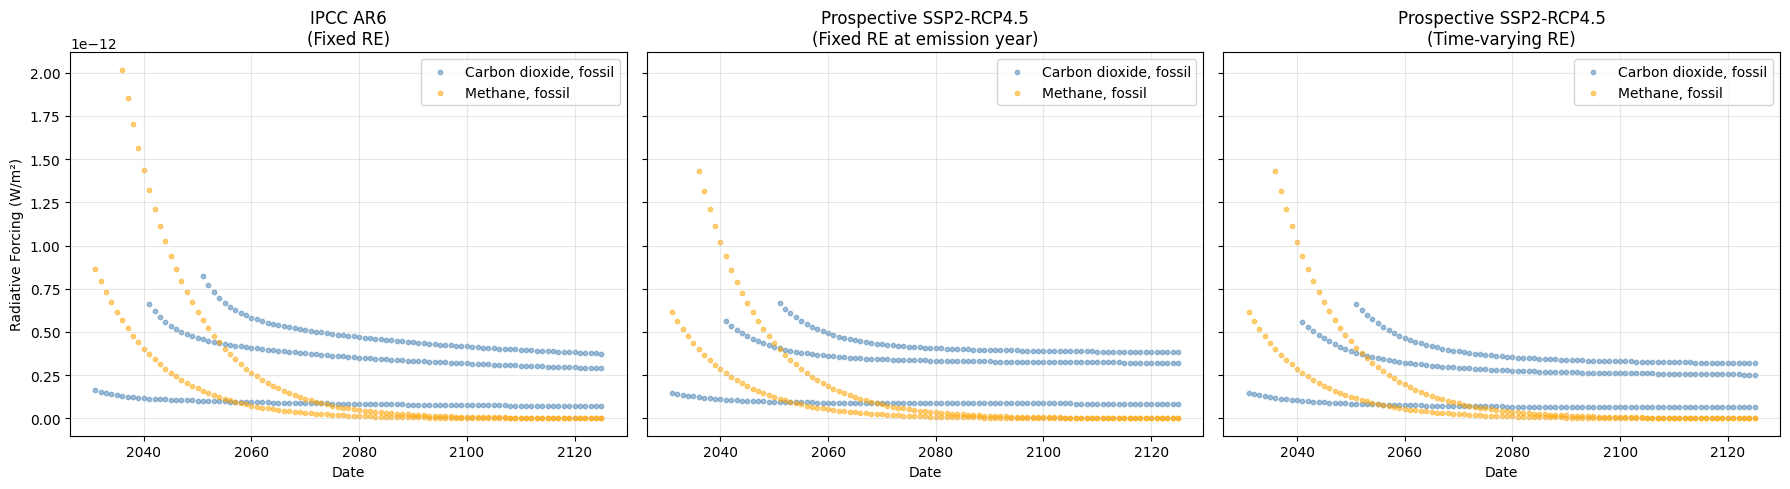

In [6]:
import matplotlib.pyplot as plt

# Get flow names for legend using the remapping dict
biosphere_map = lca.remapping_dicts["biosphere"]
flow_names = {}
for flow_id, key in biosphere_map.items():
    node = bd.get_node(database=key[0], code=key[1])
    flow_names[flow_id] = node["name"]

# Get unique flows and colors
flows = ipcc_characterized["flow"].unique()
colors = ['steelblue', 'orange', 'green', 'red']

# Create comparison scatter plot (3 subplots) using actual dates
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

# IPCC AR6 subplot
for i, flow in enumerate(flows):
    flow_data = ipcc_characterized[ipcc_characterized["flow"] == flow]
    label = flow_names.get(flow, f"Flow {flow}")
    axes[0].scatter(flow_data["date"], flow_data["amount"], 
                    alpha=0.5, s=10, color=colors[i % len(colors)], label=label)
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Radiative Forcing (W/m²)")
axes[0].set_title("IPCC AR6\n(Fixed RE)")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Prospective fixed RE subplot
for i, flow in enumerate(flows):
    flow_data = prospective_fixed_re[prospective_fixed_re["flow"] == flow]
    label = flow_names.get(flow, f"Flow {flow}")
    axes[1].scatter(flow_data["date"], flow_data["amount"], 
                    alpha=0.5, s=10, color=colors[i % len(colors)], label=label)
axes[1].set_xlabel("Date")
axes[1].set_title("Prospective SSP2-RCP4.5\n(Fixed RE at emission year)")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Prospective varying RE subplot
for i, flow in enumerate(flows):
    flow_data = prospective_varying_re[prospective_varying_re["flow"] == flow]
    label = flow_names.get(flow, f"Flow {flow}")
    axes[2].scatter(flow_data["date"], flow_data["amount"], 
                    alpha=0.5, s=10, color=colors[i % len(colors)], label=label)
axes[2].set_xlabel("Date")
axes[2].set_title("Prospective SSP2-RCP4.5\n(Time-varying RE)")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Cumulative Impact Comparison

Compare the cumulative radiative forcing over time for all methods.

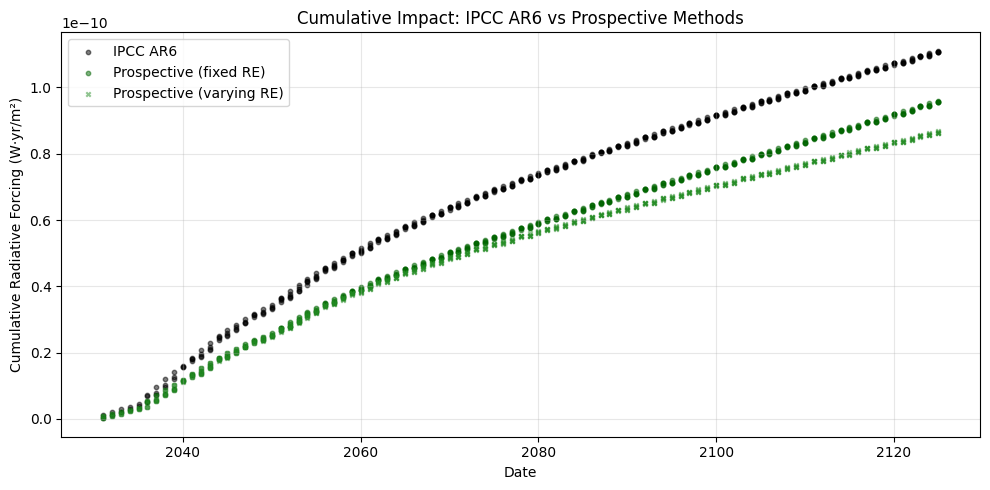


=== Summary Statistics ===
Total Cumulative RF (IPCC AR6):              1.11e-10 W·yr/m²
Total Cumulative RF (Prospective fixed RE):  9.60e-11 W·yr/m²
Total Cumulative RF (Prospective varying RE):8.68e-11 W·yr/m²

Difference (fixed RE vs IPCC):  -13.6%
Difference (varying RE vs IPCC): -21.9%


In [7]:
# Calculate cumulative impacts using actual dates (no yearly aggregation)
def calc_cumulative(df):
    df_sorted = df.sort_values("date").copy()
    df_sorted["cumulative"] = df_sorted["amount"].cumsum()
    return df_sorted

bw_ipcc_cumulative = calc_cumulative(ipcc_characterized)
bw_prospective_fixed_cumulative = calc_cumulative(prospective_fixed_re)
bw_prospective_varying_cumulative = calc_cumulative(prospective_varying_re)

# Plot cumulative comparison using actual dates (scatter plot)
fig, ax = plt.subplots(figsize=(10, 5))

ax.scatter(bw_ipcc_cumulative["date"], bw_ipcc_cumulative["cumulative"], 
           color='black', s=10, alpha=0.5, label='IPCC AR6')
ax.scatter(bw_prospective_fixed_cumulative["date"], bw_prospective_fixed_cumulative["cumulative"], 
           color='darkgreen', s=10, alpha=0.5, label='Prospective (fixed RE)')
ax.scatter(bw_prospective_varying_cumulative["date"], bw_prospective_varying_cumulative["cumulative"], 
           color='forestgreen', s=10, alpha=0.5, marker='x', label='Prospective (varying RE)')

ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Radiative Forcing (W·yr/m²)")
ax.set_title("Cumulative Impact: IPCC AR6 vs Prospective Methods")
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print summary
print("\n=== Summary Statistics ===")
print(f"Total Cumulative RF (IPCC AR6):              {bw_ipcc_cumulative['cumulative'].iloc[-1]:.2e} W·yr/m²")
print(f"Total Cumulative RF (Prospective fixed RE):  {bw_prospective_fixed_cumulative['cumulative'].iloc[-1]:.2e} W·yr/m²")
print(f"Total Cumulative RF (Prospective varying RE):{bw_prospective_varying_cumulative['cumulative'].iloc[-1]:.2e} W·yr/m²")
print(f"\nDifference (fixed RE vs IPCC):  {((bw_prospective_fixed_cumulative['cumulative'].iloc[-1] / bw_ipcc_cumulative['cumulative'].iloc[-1]) - 1) * 100:.1f}%")
print(f"Difference (varying RE vs IPCC): {((bw_prospective_varying_cumulative['cumulative'].iloc[-1] / bw_ipcc_cumulative['cumulative'].iloc[-1]) - 1) * 100:.1f}%")

## 7. Compare Multiple Scenarios

See how different SSP-RCP scenarios affect the results.

In [8]:
# Compare multiple prospective scenarios
scenarios = [
    ("IMAGE", "SSP1", "2.6", "green", "SSP1-RCP2.6 (Sustainable)"),
    ("MESSAGE", "SSP2", "4.5", "orange", "SSP2-RCP4.5 (Middle)"),
    ("REMIND", "SSP5", "8.5", "red", "SSP5-RCP8.5 (High Emissions)"),
]

scenario_results = {}

for iam, ssp, rcp, color, label in scenarios:
    prospective.set_scenario(iam=iam, ssp=ssp, rcp=rcp)
    
    result = characterize(
        dynamic_inventory,
        metric="prospective_radiative_forcing",
        base_lcia_method=method,
        time_horizon=time_horizon,
        fixed_time_horizon=True,
        time_varying_re=False,
    )
    
    cumulative = calc_cumulative(result)
    scenario_results[label] = {"data": cumulative, "color": color}

# Also add IPCC AR6 for reference
scenario_results["IPCC AR6 (Fixed)"] = {"data": bw_ipcc_cumulative, "color": "black"}

2026-01-29 15:14:46.182 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.
2026-01-29 15:14:46.338 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.
2026-01-29 15:14:46.455 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen 

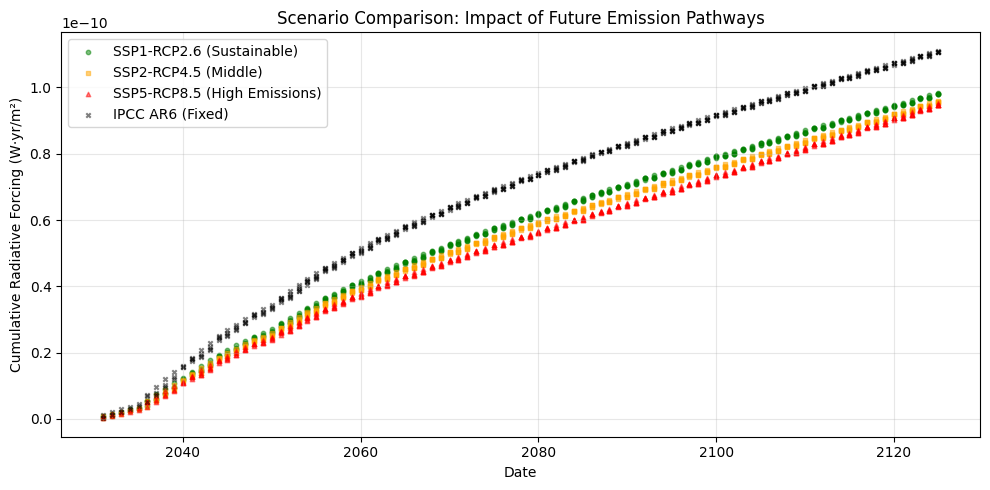


=== Final Cumulative Radiative Forcing ===
SSP1-RCP2.6 (Sustainable)          : 9.83e-11 W·yr/m²
SSP2-RCP4.5 (Middle)               : 9.60e-11 W·yr/m²
SSP5-RCP8.5 (High Emissions)       : 9.52e-11 W·yr/m²
IPCC AR6 (Fixed)                   : 1.11e-10 W·yr/m²


In [9]:
fig, ax = plt.subplots(figsize=(10, 5))

# Cumulative RF
markers = ['o', 's', '^', 'x']
for i, (label, result) in enumerate(scenario_results.items()):
    data = result["data"]
    color = result["color"]
    marker = markers[i % len(markers)]
    ax.scatter(data["date"], data["cumulative"], color=color, 
               s=10, alpha=0.5, marker=marker, label=label)

ax.set_xlabel("Date")
ax.set_ylabel("Cumulative Radiative Forcing (W·yr/m²)")
ax.set_title("Scenario Comparison: Impact of Future Emission Pathways")
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final cumulative values
print("\n=== Final Cumulative Radiative Forcing ===")
for label, result in scenario_results.items():
    final_value = result["data"]["cumulative"].iloc[-1]
    print(f"{label:35s}: {final_value:.2e} W·yr/m²")

## 8. Other Prospective Metrics: pGWP and pGTP

Beyond radiative forcing, the `dynamic_characterization` package supports other prospective climate metrics:

- **pGWP (prospective Global Warming Potential)**: The time-integrated radiative forcing relative to CO2, accounting for scenario-dependent atmospheric evolution
- **pGTP (prospective Global Temperature Potential)**: The temperature change at a specific time horizon relative to CO2, reflecting the actual warming effect

These metrics allow for different perspectives on climate impact:
- **Radiative Forcing**: Instantaneous energy imbalance (W/m²)
- **GWP**: Cumulative energy absorbed over a time horizon (dimensionless, relative to CO2)
- **GTP**: Temperature change at end of time horizon (dimensionless, relative to CO2)

In [10]:
# Characterize with prospective GWP (pGWP)
prospective.set_scenario(iam="MESSAGE", ssp="SSP2", rcp="4.5")

bw_prospective_gwp = characterize(
    dynamic_inventory,
    metric="pGWP",
    base_lcia_method=method,
    time_horizon=time_horizon,
    fixed_time_horizon=True,
)

# Characterize with prospective GTP (pGTP)
bw_prospective_gtp = characterize(
    dynamic_inventory,
    metric="pGTP",
    base_lcia_method=method,
    time_horizon=time_horizon,
    fixed_time_horizon=True,
)

print(f"Prospective GWP characterized: {len(bw_prospective_gwp)} rows")
print(f"Prospective GTP characterized: {len(bw_prospective_gtp)} rows")

2026-01-29 15:14:48.804 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.
2026-01-29 15:14:48.948 | INFO     | dynamic_characterization.dynamic_characterization:characterize:108 - No custom dynamic characterization functions provided. Using default dynamic             characterization functions. The flows that are characterized are based on the selection                of the initially chosen impact category.


Prospective GWP characterized: 5 rows
Prospective GTP characterized: 5 rows


In [11]:
# Compare cumulative impacts across all prospective metrics
bw_prospective_gwp_cumulative = calc_cumulative(bw_prospective_gwp)
bw_prospective_gtp_cumulative = calc_cumulative(bw_prospective_gtp)

print("\n=== Final Cumulative Values (All Metrics) ===")
print(f"Prospective RF:  {bw_prospective_fixed_cumulative['cumulative'].iloc[-1]:.2e} W·yr/m²")
print(f"Prospective GWP: {bw_prospective_gwp_cumulative['cumulative'].iloc[-1]:.2e} kg CO2-eq")
print(f"Prospective GTP: {bw_prospective_gtp_cumulative['cumulative'].iloc[-1]:.2e} kg CO2-eq")


=== Final Cumulative Values (All Metrics) ===
Prospective RF:  9.60e-11 W·yr/m²
Prospective GWP: 1.11e+03 kg CO2-eq
Prospective GTP: 1.03e+03 kg CO2-eq
